All code originated from https://pytorch.org/tutorials/advanced/neural_style_tutorial.html

## Environment

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My\ Drive/NYU/ML_Sundeep/project

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/NYU/ML_Sundeep/project


In [2]:
# !wget --output-document data/style_images/starnight.jpg "http://vr.theatre.ntu.edu.tw/fineart/painter-wt/vangogh/vangogh-1889-2x.jpg"
# !wget --output-document data/style_images/monalisa_smile.jpg "https://upload.wikimedia.org/wikipedia/commons/6/6a/Mona_Lisa.jpg"
# !wget --output-document data/style_images/vango_self.jpg "https://www.quotemaster.org/images/7e/7e7bd2e8b735eaac2a89b37f3b923636.jpg"
# !wget --output-document data/style_images/japan_paint_wave.jpg "https://raw.githubusercontent.com/lengstrom/fast-style-transfer/master/examples/thumbs/wave.jpg"

# !wget --output-document data/content_images/annakendrick47_snow.jpg "https://scontent-lga3-2.cdninstagram.com/v/t51.2885-15/e35/49741144_289942465045069_2468300994106805241_n.jpg?_nc_ht=scontent-lga3-2.cdninstagram.com&_nc_cat=101&_nc_ohc=q5NFRFK6Y0MAX9Q5D3M&tp=1&oh=cdbef71404090bdbea18b65784d15d64&oe=5FF4193B"
# !wget --output-document data/content_images/church.jpg "https://raw.githubusercontent.com/jcjohnson/neural-style/master/examples/inputs/hoovertowernight.jpg"
# !wget --output-document data/content_images/river_house.jpg "https://raw.githubusercontent.com/animesh-s/Neural-Style-Transfer/master/images/content/neckarfront.jpg"

In [11]:
import os
import numpy as np
import argparse
from PIL import Image
import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.utils import save_image

import copy # to deep copy the models; system package

## Parameter Setting

In [12]:
parser = {
    "root": os.getcwd(),
    "seed": 1,
    "cuda": True,
    "num_steps": 30,
    "style_weight": 100000, 
    "content_weight": 1,
    "content_layers_default": ['conv_4'],
    "style_layers_default": ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5'],
    "cnn_nor_mean": [0.485, 0.456, 0.406],
    "cnn_nor_std": [0.229, 0.224, 0.225],
    "imsize": (1000, 800),
    "style_image": "data/style_images/japan_paint_wave.jpg",
    "content_image": "data/content_images/polar_bear.jpg",
    "transfer_image": "data/content_images/polar_bear__japan_paint_wave.jpg",
}
config = argparse.Namespace(**parser)
device = torch.device('cuda') if torch.cuda.is_available() and config.cuda else torch.device('cpu')

## Get Model

#### Get image function

In [5]:
def image_loader(image_name, imsize=config.imsize):
    """ image file name -> tensor """
    image = Image.open(image_name)
    loader = transforms.Compose([
                             transforms.Resize(config.imsize),  # scale imported image
                             transforms.ToTensor(),   # transform it into a torch tensor
                             ])
    image = loader(image).unsqueeze(0)
    return image

def imshow(tensor):
    """ display image """
    unloader = transforms.ToPILImage()
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)

#### Loss function tuning: Style + Content

In [6]:
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()
    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()
    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL
    G = torch.mm(features, features.t())  # compute the gram product
    return G.div(a * b * c * d)

#### Model construction

In [7]:
class Normalization(nn.Module):
    def __init__(self, config):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(config.cnn_nor_mean,).view(-1, 1, 1).to(device)
        self.std = torch.tensor(config.cnn_nor_std).view(-1, 1, 1).to(device)
    def forward(self, img):
        return (img - self.mean)/self.std

def get_style_model_and_losses(config, cnn, style_img, content_img):
    cnn = copy.deepcopy(cnn)

    normalization = Normalization(config).to(device)
    
    content_losses = []
    style_losses = []

    model = nn.Sequential(normalization)
    
    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in config.content_layers_default: # add content loss
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in config.style_layers_default: # add style loss
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

## Training

In [8]:
def get_input_optimizer(input_img): # this line to show that input is a parameter that requires a gradient
    return optim.LBFGS([input_img.requires_grad_()])

def run_style_transfer(config, cnn, content_img, style_img, input_img):
    model, style_losses, content_losses = get_style_model_and_losses(config, cnn, style_img, content_img)
    optimizer = get_input_optimizer(input_img)
    for _ in tqdm.tqdm_notebook(range(config.num_steps)):
        def closure():
            """ LBFGS need to reevaluate the function multiple times, so you have to pass in a closure that allows them to recompute your model """
            input_img.data.clamp_(0, 1) # correct the values of updated input image
            optimizer.zero_grad()
            model(input_img)
            style_score = config.style_weight*sum([sl.loss for sl in style_losses])
            content_score = config.content_weight*sum([cl.loss for cl in content_losses])
            loss = style_score + content_score
            loss.backward()
            return style_score + content_score
        optimizer.step(closure)

    input_img.data.clamp_(0, 1) # a last correction
    return input_img

In [9]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

style_img = image_loader(config.style_image).to(device, torch.float)
content_img = image_loader(config.content_image).to(device, torch.float)
input_img = content_img.clone()

output = run_style_transfer(config, cnn, content_img, style_img, input_img)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


torch.Size([1, 3, 1000, 800])


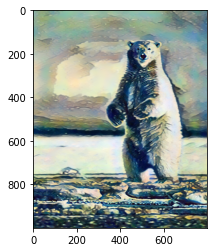

In [13]:
print(output.shape)
imshow(output)

In [14]:
save_image(output[0], config.transfer_image)